<a href="https://colab.research.google.com/github/kumastry/cs_stress_majorization/blob/main/%E3%82%B3%E3%83%B3%E3%83%94%E3%83%A5%E3%83%BC%E3%82%BF%E7%A7%91%E5%AD%A6%E7%89%B9%E8%AB%961.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!curl -o graph.zip https://esa-storage-tokyo.s3-ap-northeast-1.amazonaws.com/uploads/production/attachments/8704/2022/06/24/28750/8be3d27d-7c30-471a-a609-ce2ed4ba50fc.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  214k  100  214k    0     0   201k      0  0:00:01  0:00:01 --:--:--  201k


In [4]:
!mkdir -p result

In [5]:
!unzip -o graph.zip

Archive:  graph.zip
  inflating: graph/1138_bus.json     
  inflating: graph/3elt.json         
  inflating: graph/bull.json         
  inflating: graph/chvatal.json      
  inflating: graph/cubical.json      
  inflating: graph/davis_southern_women.json  
  inflating: graph/desargues.json    
  inflating: graph/diamond.json      
  inflating: graph/dodecahedral.json  
  inflating: graph/dwt_1005.json     
  inflating: graph/dwt_2680.json     
  inflating: graph/florentine_families.json  
  inflating: graph/frucht.json       
  inflating: graph/heawood.json      
  inflating: graph/hoffman_singleton.json  
  inflating: graph/house.json        
  inflating: graph/house_x.json      
  inflating: graph/icosahedral.json  
  inflating: graph/karate_club.json  
  inflating: graph/krackhardt_kite.json  
  inflating: graph/les_miserables.json  
  inflating: graph/moebius_kantor.json  
  inflating: graph/octahedral.json   
  inflating: graph/pappus.json       
  inflating: graph/petersen.json  

In [6]:
UNIT_EDGE_LENGTH = 30

In [7]:
import glob
import json
import os.path
import pandas as pd
import networkx as nx
records = []
for filename in glob.glob('graph/*.json'):
    graph = nx.node_link_graph(json.load(open(filename)))
    records.append([
        os.path.basename(filename),
        graph.number_of_nodes(),
        graph.number_of_edges(),
        nx.is_connected(graph),
    ])
df = pd.DataFrame(records, columns=['filename', 'number_of_nodes', 'number_of_edges', 'is_connected'])
df

,filename,number_of_nodes,number_of_edges,is_connected
0,pappus.json,18,27,True
1,house_x.json,5,8,True
2,poli.json,3915,4119,False
3,dwt_2680.json,2680,11173,True
4,house.json,5,6,True
5,heawood.json,14,21,True
6,cubical.json,8,12,True
7,krackhardt_kite.json,10,18,True
8,desargues.json,20,30,True
9,sedgewick_maze.json,8,10,True


In [8]:
from math import sqrt
from random import random
from networkx import floyd_warshall_numpy
from scipy.sparse.linalg import cg
import numpy as np

def inv(x):
    if x < 1e-4:
        return 0.0
    return 1 / x


def stress(X, D):
    n = len(X)
    s = 0
    for i in range(n):
        X_i = X[i, :]
        for j in range(i):
            X_j = X[j, :]
            d = np.linalg.norm(X_i - X_j) - D[i, j]
            s += d * d
    return s



def stress_majorization(graph):
    epsilon = 1e-4
    n = graph.number_of_nodes()
    D = floyd_warshall_numpy(graph)
    print(D)
    w = np.zeros((n, n))
    delta = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            w[i, j] = w[j, i] = D[i, j] ** -2
            delta[i, j] = delta[j, i] = w[i, j] * D[i, j]
    Z = np.random.rand(n, 2)
    Z[0] = (0., 0.)
    L_w = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            L_w[i, j] = L_w[j, i] = -w[i, j]
    for i in range(n):
        L_w[i, i] = -sum(L_w[i, :])
    e0 = stress(Z, D)
    while True:
        L_Z = np.zeros((n, n))
        for i in range(n):
            Z_i = Z[i, :]
            for j in range(i):
                Z_j = Z[j, :]
                L_Z[i, j] = L_Z[j, i] = -delta[i, j] * inv(np.linalg.norm(Z_i - Z_j))
        for i in range(n):
            L_Z[i][i] = -sum(L_Z[i, :])
        Z[1:, 0] = cg(L_w[1:, 1:], (L_Z @ Z[:, 0])[1:])[0]
        Z[1:, 1] = cg(L_w[1:, 1:], (L_Z @ Z[:, 1])[1:])[0]
        e = stress(Z, D)
        if (e0 - e) / e0 < epsilon:
            break
        e0 = e
    return {u: Z[i] for i, u in enumerate(graph.nodes())}

In [30]:
import random
import numpy as np
import math

def floyd_warshall_dij(graph):
  idx = 0
  label_dict = {}
  for u in graph.nodes:
    label_dict[u] = idx
    idx += 1

  dij = []
  shortest_path_dict  = nx.floyd_warshall(graph)

  for i , dics in shortest_path_dict.items():
    vec = [0] * len(graph.nodes)
    for dic in dics.items():
      vec[label_dict[dic[0]]] = dic[1]
    dij.append(vec)
  print(dij)
  return dij

def SGD(graph):
  n = len(graph.nodes)
  k = 2
  d = floyd_warshall_dij(graph)
  X = np.ones((n, k))
  size = UNIT_EDGE_LENGTH * graph.number_of_nodes() ** 0.5
  for i in range(n):
    for j in range(k):
      X[i][j] =   random.random() * size

  eta = 1000
  lamda = 2
  tmax = 15

  ordered_each = []

  for i in range(n):
    for j in range(i+1, n):
      ordered_each.append((i, j))

  random.shuffle(  ordered_each )

  for t in range(tmax):
    for i,j in ordered_each:
      wij  = d[i][j] ** -2
      mu = min(eta*wij, 1)
      nodes_norm = np.linalg.norm(X[i]-X[j])
      r = ( nodes_norm  -   d[i][j])  /  2.0  / nodes_norm * (X[i] - X[j])
      #print(d[i][j], mu, eta)
      #print(nodes_norm)
      #print(r)

      mu = max(0.1, mu)
      X[i] -= mu * r
      X[j] += mu * r
    eta = 50* math.exp(-lamda*t)
    # print(eta)
    # print(X)
  return  { u : (v[0], v[1])  for (u, v) in zip(graph.nodes , X) }

In [37]:
import json
import networkx as nx
name =  'tutte'
graph = nx.node_link_graph(json.load(open(f'graph/{name}.json')))
pos = SGD(graph)
# print(pos)
# print(graph.edges)

[[0, 1.0, 1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 2.0, 2.0, 3.0, 4.0, 5.0, 5.0, 4.0, 3.0, 2.0, 2.0, 3.0, 4.0, 5.0, 5.0, 4.0, 3.0, 2.0, 5.0, 5.0, 4.0, 4.0, 4.0, 5.0, 3.0, 5.0, 4.0, 4.0, 4.0, 5.0, 3.0, 5.0, 4.0, 4.0, 4.0, 5.0, 3.0], [1.0, 0, 2.0, 2.0, 1.0, 2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 3.0, 4.0, 5.0, 5.0, 6.0, 5.0, 4.0, 3.0, 3.0, 4.0, 5.0, 6.0, 4.0, 3.0, 2.0, 1.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 2.0, 6.0, 5.0, 5.0, 5.0, 6.0, 4.0, 6.0, 5.0, 5.0, 5.0, 6.0, 4.0], [1.0, 2.0, 0, 2.0, 3.0, 4.0, 5.0, 4.0, 3.0, 2.0, 1.0, 1.0, 2.0, 3.0, 4.0, 4.0, 5.0, 4.0, 3.0, 3.0, 4.0, 5.0, 5.0, 6.0, 5.0, 4.0, 3.0, 6.0, 6.0, 5.0, 5.0, 5.0, 6.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 2.0, 6.0, 5.0, 5.0, 5.0, 6.0, 4.0], [1.0, 2.0, 2.0, 0, 3.0, 4.0, 5.0, 6.0, 5.0, 4.0, 3.0, 3.0, 4.0, 5.0, 6.0, 4.0, 3.0, 2.0, 1.0, 1.0, 2.0, 3.0, 4.0, 4.0, 5.0, 4.0, 3.0, 5.0, 6.0, 5.0, 5.0, 5.0, 6.0, 4.0, 6.0, 5.0, 5.0, 5.0, 6.0, 4.0, 4.0, 3.0, 3.0, 3.0, 4.0, 2.0], [2.0, 1.0, 3.0, 3.0, 0, 1.0, 2.0, 3.0, 4.0, 5.0, 4.0, 4.0, 5.0, 5.0, 4.0, 6.0, 

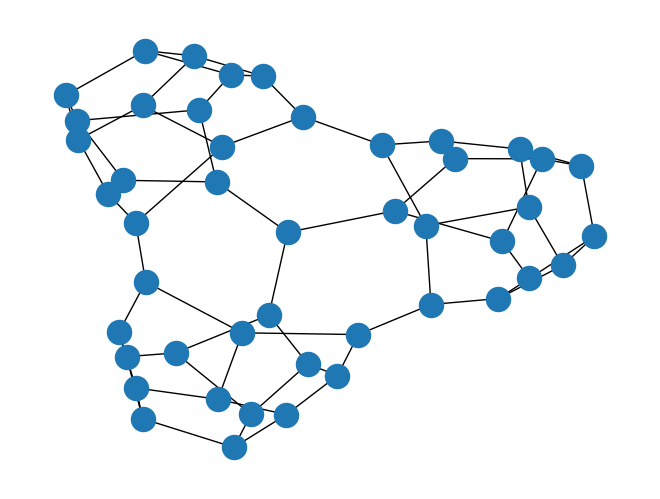

In [38]:
# 描画結果の表示
nx.draw(graph, pos)

In [39]:
# 描画結果の評価
import itertools
import math
d = dict(nx.all_pairs_dijkstra_path_length(graph, weight=lambda u, v, e: UNIT_EDGE_LENGTH))
s = 0
for u, v in itertools.combinations(graph.nodes, 2):
    s += (math.hypot(pos[u][0] - pos[v][0], pos[u][1] - pos[v][0]) - d[u][v]) ** 2 / d[u][v] ** 2
s

844.4228710848137

In [27]:
# 描画結果の保存
json.dump(pos, open(f'result/{name}.json', 'w'))